In [1]:
import numpy as np
import os
import sys
import re
import h5py
import cv2
import importlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# from caiman.base.rois import register_multisession, register_ROIs

sys.path.insert(0, os.path.abspath(r'C:/Users/mmccann/repos/bonhoeffer/prey_capture/'))
import paths
import processing_parameters
import functions_bondjango as bd
import functions_misc as fm
import functions_plotting as fplot
import functions_data_handling as fdh

In [2]:
importlib.reload(processing_parameters)

# get the search string
search_string = processing_parameters.search_string + r", analysistype:calciumraw"
parsed_search = parsed_search = fdh.parse_search_string(search_string)

# get the paths from the database
file_infos = bd.query_database('analyzed_data', search_string)
calcium_paths = np.array([el['analysis_path'] for el in file_infos if ('calciumraw' in el['slug']) and
                            (parsed_search['mouse'].lower() in el['slug'])])
cell_matching_path = [el['analysis_path'] for el in file_infos if ('daycellmatch' in el['slug']) and
                            (parsed_search['mouse'].lower() in el['slug'])]
print(calcium_paths)
print(cell_matching_path)

['Z:\\Prey_capture\\AnalyzedData\\08_10_2023_15_37_30_VTuningWF_MM_230706_b_free0_gabor_calciumraw.hdf5'
 'Z:\\Prey_capture\\AnalyzedData\\08_10_2023_16_04_44_VWheelWF_MM_230706_b_fixed1_gabor_calciumraw.hdf5']
['Z:\\Prey_capture\\AnalyzedData\\08_10_2023_MM_230706_b_dayCellMatch.hdf5']


In [3]:
def register_session(experiment_list):
    footprint_list = []
    size_list = []
    template_list = []
    
    for files in experiment_list:
        with h5py.File(files, mode='r') as f:

            try:
                calcium_data = np.array(f['A'])
            except KeyError:
                continue

            # if there are no ROIs, skip
            if (type(calcium_data) == np.ndarray) and np.any(calcium_data.astype(str) == 'no_ROIs'):
                continue
            # clear the rois that don't pass the size criteria
            areas = fm.get_roi_stats(calcium_data)[:, -1]
            keep_vector = (areas > processing_parameters.roi_parameters['area_min']) & \
                          (areas < processing_parameters.roi_parameters['area_max'])

            if np.all(keep_vector == False):
                continue

            calcium_data = calcium_data[keep_vector, :, :]

            # format and masks and store for matching

            footprint_list.append(np.moveaxis(calcium_data, 0, -1).reshape((-1, calcium_data.shape[0])))
            size_list.append(calcium_data.shape[1:])
            template_list.append(np.zeros(size_list[0]))
    
    # Run the  registration and filter the matched cells
    spatial_union, assignments, matchings = register_multisession(
        A=footprint_list, dims=size_list[0], templates=template_list, max_thr=0, thresh_cost=0.8, max_dist=13)

    n_reg = 2  # minimal number of sessions that each component has to be registered in

    # Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
    assignments_filtered = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg], dtype=int);

    # Use filtered indices to select the corresponding spatial components
    spatial_filtered = footprint_list[0][:, assignments_filtered[:, 0]]
    
    return assignments_filtered

In [4]:
# load the data for the matching
calcium_list = []
footprint_list = []
size_list = []
template_list = []
footprint_pics = []
rigs = []
centroids = []

# load the calcium data
for files in calcium_paths:
    with h5py.File(files, mode='r') as f:

        try:
            calcium_data = np.array(f['A'])
        except KeyError:
            continue

    # if there are no ROIs, skip
    if (type(calcium_data) == np.ndarray) and np.any(calcium_data.astype(str) == 'no_ROIs'):
        continue
        
    # clear the rois that don't pass the size criteria
    areas = fm.get_roi_stats(calcium_data)[:, -1]
    keep_vector = (areas > processing_parameters.roi_parameters['area_min']) & \
                  (areas < processing_parameters.roi_parameters['area_max'])

    if np.all(keep_vector == False):
        continue

    calcium_data = calcium_data[keep_vector, :, :]
    calcium_list.append(calcium_data)
    
    # format and masks and store for matching
    
    footprint_list.append(np.moveaxis(calcium_data, 0, -1).reshape((-1, calcium_data.shape[0])))
    size_list.append(calcium_data.shape[1:])
    template_list.append(np.zeros(size_list[0]))
    footprint_pics.append(np.sum(calcium_data, axis=0))
    
    cents = []
    for cell in calcium_data:
        new_cell = cell.copy()
        new_cell[new_cell > 0] == 1 
        M = cv2.moments(new_cell)
        # centroid calciulation
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cents.append((cX, cY))

    centroids.append(cents)
    
    rig = os.path.basename(files).split('_')[6]
    rigs.append(rig)

In [5]:
if len(cell_matching_path) == 0:
    spatial_union, assignments, matchings = register_multisession(
            A=footprint_list, dims=size_list[0], templates=template_list, max_thr=0, thresh_cost=0.8, max_dist=13)
    
    n_reg = 2  # minimal number of sessions that each component has to be registered in
    
    # Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
    assignments_filtered = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg], dtype=int);
    
    # Use filtered indices to select the corresponding spatial components
    spatial_filtered = footprint_list[0][:, assignments_filtered[:, 0]]
    matched_footprints = np.sum(spatial_filtered.reshape(320, 320, spatial_filtered.shape[-1]), axis=-1)

else:
    # Load the cell matched if they exist
    with h5py.File(cell_matching_path[0], 'r') as f:
        # load the variables of interest
        assignments = np.array(f['assignments'])
        date_list = np.array(f['date_list']).astype(str)
        cell_matches = pd.DataFrame(data=assignments, columns=date_list)
        cell_matches = cell_matches.dropna().reset_index(drop=True).astype(int)
        
    spatial_filtered = calcium_list[0][cell_matches.iloc[:, 1].astype(int), :]
    matched_footprints = np.sum(spatial_filtered, axis=0)

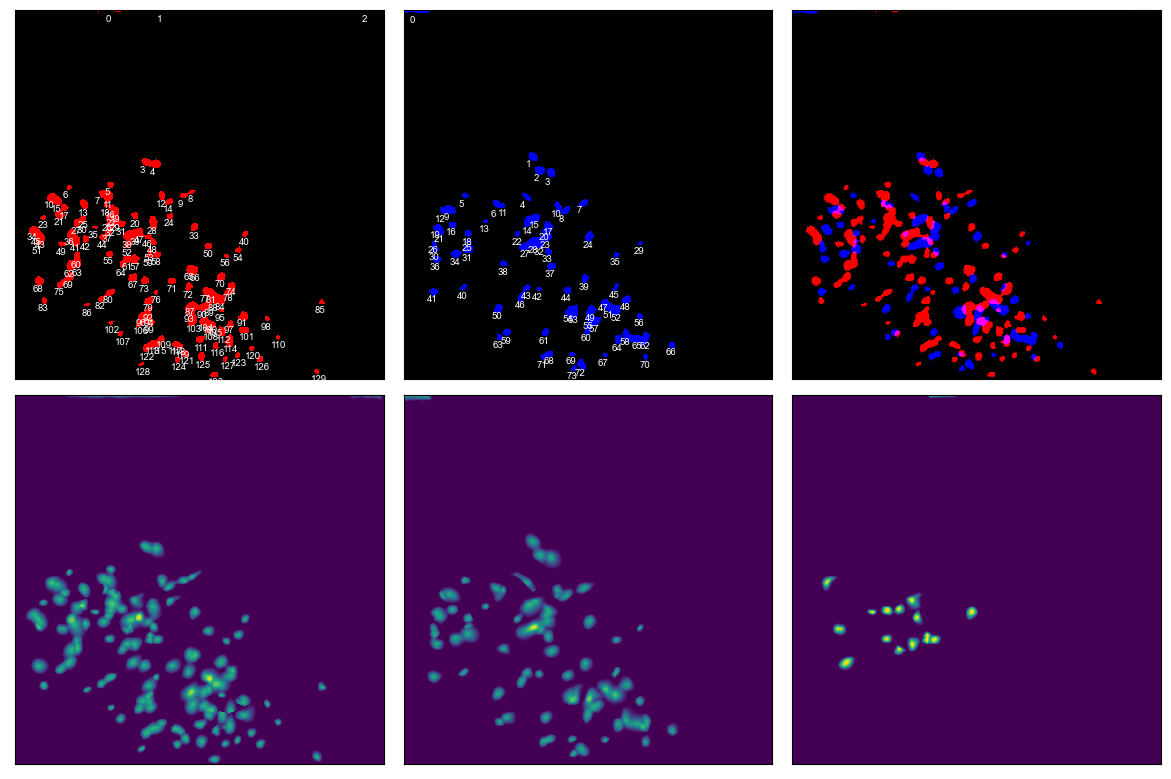

In [7]:
binary_images = []
for pic in footprint_pics:
    bin_pic = np.zeros_like(pic)
    bin_pic[pic >= 0.6] = 1
    binary_images.append(bin_pic)


plt.rcParams["font.family"] = "Arial"
# plt.rcParams['font.size'] = 15
cm = 1./2.54
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30*cm,20*cm))
cmaps=[ListedColormap(['black','red']), ListedColormap(['black','blue'])]
for i, (rig, bin_pic, foot_pic, cents, cmap) in enumerate(zip(['Freely Moving', 'Head Fixed'], binary_images, footprint_pics, centroids, cmaps)):
    axes[0, i].imshow(bin_pic, cmap=cmap)
    axes[1, i].imshow(foot_pic)
    # axes[0, i].set_title(rig)
    for num, cent in enumerate(cents):
        axes[0, i].text(cent[0]-5, cent[1]+10, str(num), c='w', fontsize='x-small')

axes[0, -1].imshow(np.dstack((binary_images[0], np.zeros_like(binary_images[0]), binary_images[1])))
axes[1, -1].imshow(matched_footprints)
# axes[0, -1].set_title("Overlay")

for ax in axes.flatten():
    # # Hide X and Y axes label marks
    # ax.xaxis.set_tick_params(labelbottom=False)
    # ax.yaxis.set_tick_params(labelleft=False)
    
    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

In [9]:
figure_save_path = r"C:\Users\mmccann\Dropbox\bonhoeffer lab\SFN 2023\poster"
fig.savefig(os.path.join(figure_save_path, 'Fig3', 'cell_matching.png'), dpi=600, format='png')